In [2]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
import pickle
import seg_metrics.seg_metrics as sg

/home/daryl/miniconda3/envs/py310/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### calculate the metrics for a dataset and test patient ID

In [3]:
DATASET_ID = 144
TEST_ID = 1

In [5]:
prediction_img = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_predictions/Dataset{}_RNSH_HFlung/post/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()


In [6]:
label_img = nib.load('/mnt/data/datasets/RNSH_HFlung/nnU-Net-processing/nnUNet_raw/Dataset{}_RNSH_HFlung/labelsTs/RNSH_HFlung_{:04d}.nii.gz'.format(DATASET_ID, TEST_ID)).get_fdata()

In [7]:
DISPLAY_IDX = 100

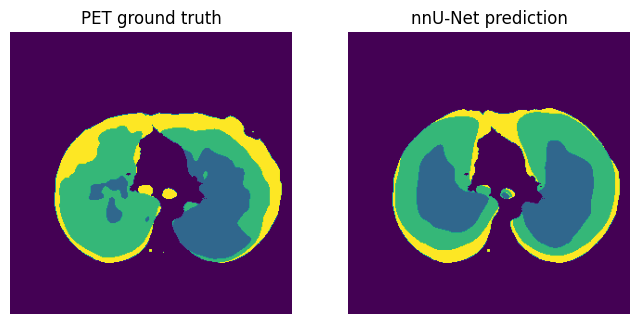

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.imshow(label_img[:,:,DISPLAY_IDX])
ax1.set_title('PET ground truth')
ax1.set_axis_off()

ax2.imshow(prediction_img[:,:,DISPLAY_IDX])
ax2.set_title('nnU-Net prediction')
ax2.set_axis_off()

In [259]:
seg = prediction_img.ravel()
gt = label_img.ravel()

In [260]:
foreground_idxs = gt > 0

sp = spearmanr(seg[foreground_idxs], gt[foreground_idxs])
print('Spearman')
print(np.round(sp[0],2))

Spearman
0.49


In [261]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [262]:
cm = confusion_matrix(label_img.ravel(), prediction_img.ravel())
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

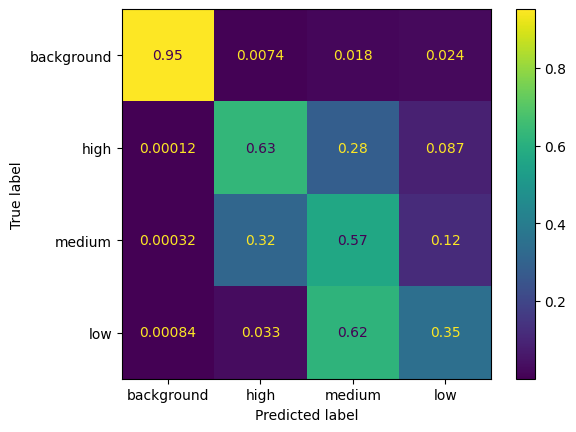

In [263]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()

In [264]:
dsc = {}
print('DSC')
for idx,label in enumerate(['high','medium','low']):
    k = idx+1
    dice = np.sum(seg[gt==k]==k)*2.0 / (np.sum(seg[seg==k]==k) + np.sum(gt[gt==k]==k))
    dsc[label] = dice
    print('{}: {}'.format(label, round(dice,2)))

DSC
high: 0.58
medium: 0.46
low: 0.36


In [265]:
labels = [0, 1, 2, 3]

metrics = sg.write_metrics(labels=labels,
                  gdth_img=label_img,
                  pred_img=prediction_img,
                  csv_file=None,
                  metrics=['vs','hd','hd95'])

1it [00:11, 11.03s/it]


In [266]:
vs = metrics[0]['vs']
print('volume similarity')
print('high: {}'.format(round(vs[1],2)))
print('medium: {}'.format(round(vs[2],2)))
print('low: {}'.format(round(vs[3],2)))

volume similarity
high: -0.17
medium: -0.36
low: 0.07


In [267]:
hd = metrics[0]['hd']
print('Hausdorff distance')
print('high: {}'.format(round(hd[1])))
print('medium: {}'.format(round(hd[2])))
print('low: {}'.format(round(hd[3])))

Hausdorff distance
high: 54
medium: 48
low: 75


In [268]:
hd95 = metrics[0]['hd95']
print('Hausdorff distance 95% percentile')
print('high: {}'.format(round(hd95[1])))
print('medium: {}'.format(round(hd95[2])))
print('low: {}'.format(round(hd95[3])))

Hausdorff distance 95% percentile
high: 25
medium: 20
low: 35


#### store the metrics by dataset and test patient ID

In [269]:
ANALYSIS_DIR = '/home/daryl/analysis'
ANALYSIS_FILE = '{}/nnunet-metrics.pkl'.format(ANALYSIS_DIR)

In [270]:
if not os.path.exists(ANALYSIS_DIR):
    os.makedirs(ANALYSIS_DIR)

patient_d = {'dataset_id':DATASET_ID, 'test_id':TEST_ID, 
             'confusion_matrix':cm, 'spearman_correlation':np.round(sp[0],2), 
             'DSC_low':np.round(dsc['low'],2), 'DSC_medium':np.round(dsc['medium'],2), 'DSC_high':np.round(dsc['high'],2),
             'VS_low':np.round(vs[3],2), 'VS_medium':np.round(vs[2],2), 'VS_high':np.round(vs[1],2),
             'HD_low':np.round(hd[3]), 'HD_medium':np.round(hd[2]), 'HD_high':np.round(hd[1]),
             'HD95_low':np.round(hd95[3]), 'HD95_medium':np.round(hd95[2]), 'HD95_high':np.round(hd95[1]),
            }

if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
else:
    analysis_d = {}

patient_id = '{:03d}-{:02d}'.format(DATASET_ID, TEST_ID)
analysis_d[patient_id] = patient_d

with open(ANALYSIS_FILE, 'wb') as f:
        pickle.dump(analysis_d, f)

#### calculate the mean performance over all training sets

In [271]:
ANALYSIS_DIR = '/home/daryl/analysis'
ANALYSIS_FILE = '{}/nnunet-metrics.pkl'.format(ANALYSIS_DIR)

In [272]:
if os.path.isfile(ANALYSIS_FILE):
    with open(ANALYSIS_FILE, 'rb') as f:
        analysis_d = pickle.load(f)
        print('loaded {} metrics: {}'.format(len(analysis_d), list(analysis_d.keys())))
else:
    print('could not load the analysis file from {}'.format(ANALYSIS_FILE))

loaded 10 metrics: ['140-00', '140-01', '141-00', '141-01', '142-00', '142-01', '143-00', '143-01', '144-00', '144-01']


In [273]:
print('Spearman correlation')
print('mean {}, std {}'.format(round(np.mean([value['spearman_correlation'] for key, value in analysis_d.items()]) ,2), round(np.std([value['spearman_correlation'] for key, value in analysis_d.items()]), 2)))
print()
print('DSC')
print('high {}, std {}'.format(round(np.mean([value['DSC_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['DSC_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['DSC_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['DSC_low'] for key, value in analysis_d.items()]), 2)))
print()
print('volume similarity')
print('high {}, std {}'.format(round(np.mean([value['VS_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['VS_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['VS_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['VS_low'] for key, value in analysis_d.items()]), 2)))
print()
print('Hausdorff distance')
print('high {}, std {}'.format(round(np.mean([value['HD_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['HD_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['HD_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD_low'] for key, value in analysis_d.items()]), 2)))
print()
print('Hausdorff distance 95% percentile')
print('high {}, std {}'.format(round(np.mean([value['HD95_high'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD95_high'] for key, value in analysis_d.items()]), 2)))
print('medium {}, std {}'.format(round(np.mean([value['HD95_medium'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD95_medium'] for key, value in analysis_d.items()]), 2)))
print('low {}, std {}'.format(round(np.mean([value['HD95_low'] for key, value in analysis_d.items()]) ,2), round(np.std([value['HD95_low'] for key, value in analysis_d.items()]), 2)))


Spearman correlation
mean 0.44, std 0.07

DSC
high 0.57, std 0.05
medium 0.48, std 0.05
low 0.48, std 0.06

volume similarity
high 0.08, std 0.21
medium -0.15, std 0.16
low -0.06, std 0.13

Hausdorff distance
high 68.5, std 12.53
medium 52.8, std 9.68
low 62.7, std 9.24

Hausdorff distance 95% percentile
high 31.8, std 7.41
medium 19.7, std 3.77
low 25.1, std 5.87


In [274]:
cm_mean = np.mean([value['confusion_matrix'] for key, value in analysis_d.items()], axis=0)

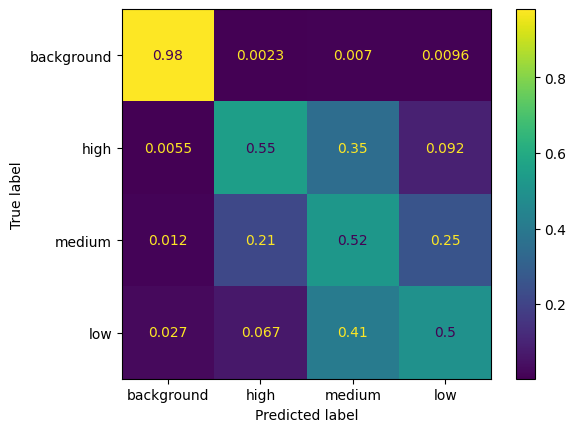

In [275]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean, display_labels=['background','high','medium','low'])
disp.plot()
plt.show()